In [33]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import (
    average_precision_score, roc_auc_score,
    precision_recall_curve, roc_curve, auc
)

# keep your repo structure
sys.path.insert(0, '../')

from common.common import create_folder, load_obj
from dataLoader.utils import seq_padding, position_idx, index_seg
import pytorch_pretrained_bert as Bert
from model.utils import age_vocab
from model import optimiser


In [34]:
file_config = {
    'vocab': '../../outputs/vocab',
    'train': '../../outputs/nextvisit_train_idx.parquet',
    'test':  '../../outputs/nextvisit_test_idx.parquet',
}

optim_config = {
    'lr': 5e-5,
    'warmup_proportion': 0.1,
    'weight_decay': 0.01
}

global_params = {
    'batch_size': 128,
    'gradient_accumulation_steps': 1,
    'device': 'cuda:0' if torch.cuda.is_available() else 'cpu',
    'output_dir': '../../outputs/ckpts',
    'best_name': 'nextvisit_12m.pt',   # BEHRT best ckpt name
    'save_model': True,
    'max_len_seq': 100,
    'max_age': 110,
    'month': 1,
    'age_symbol': None,
    'min_visit': 5
}

pretrain_ckpt = "../../outputs/ckpts/mlm_bert.pt"  # MLM pretrain

OUT_DIR = global_params['output_dir']
create_folder(OUT_DIR)

device = torch.device(global_params['device'])
print("device =", device)


device = cuda:0


In [35]:
BertVocab = load_obj(file_config['vocab'])
ageVocab, _ = age_vocab(
    max_age=global_params['max_age'],
    mon=global_params['month'],
    symbol=global_params['age_symbol']
)

def ensure_special_tokens(token2idx):
    base = ['[UNK]', '[PAD]', '[CLS]', '[SEP]', '[MASK]']
    for sp in base:
        if sp not in token2idx:
            token2idx[sp] = len(token2idx)

    alias = {'UNK':'[UNK]','PAD':'[PAD]','CLS':'[CLS]','SEP':'[SEP]','MASK':'[MASK]'}
    for a, b in alias.items():
        if a not in token2idx:
            token2idx[a] = token2idx[b]
    return token2idx

BertVocab['token2idx'] = ensure_special_tokens(BertVocab['token2idx'])

def build_label_vocab(token2idx):
    token2idx = token2idx.copy()
    for sp in ['PAD','[PAD]','SEP','[SEP]','CLS','[CLS]','MASK','[MASK]','UNK','[UNK]']:
        if sp in token2idx:
            del token2idx[sp]
    return {tok:i for i, tok in enumerate(token2idx.keys())}

Vocab_diag = build_label_vocab(BertVocab['token2idx'])

print("✅ word vocab size:", len(BertVocab['token2idx']))
print("✅ label vocab size:", len(Vocab_diag))

mlb = MultiLabelBinarizer(classes=list(Vocab_diag.values()))
mlb.fit([[i] for i in list(Vocab_diag.values())])
print("✅ mlb fitted, n_labels =", len(mlb.classes_))


✅ word vocab size: 4807
✅ label vocab size: 4797
✅ mlb fitted, n_labels = 4797


In [36]:
def code2index_safe(tokens, token2idx):
    if isinstance(tokens, np.ndarray):
        tokens_list = tokens.tolist()
    else:
        tokens_list = list(tokens)

    if "UNK" in token2idx:
        unk_id = token2idx["UNK"]
    elif "[UNK]" in token2idx:
        unk_id = token2idx["[UNK]"]
    else:
        unk_id = 0

    out = []
    for t in tokens_list:
        if not isinstance(t, str):
            t = str(t)
        out.append(token2idx.get(t, unk_id))
    return tokens_list, out


class NextVisit(Dataset):
    """
    returns 9 fields:
      age_ids, code_ids, posi_ids, seg_ids, attMask, label_ids, patid, visit_ids, code_tokens
    """
    def __init__(self, token2idx, diag2idx, age2idx, dataframe, max_len):
        self.vocab = token2idx
        self.label_vocab = diag2idx
        self.age2idx = age2idx
        self.max_len = int(max_len)

        self.code = dataframe["code"]
        self.age = dataframe["age"]
        self.label = dataframe["label"]

        if "patid" in dataframe.columns:
            self.patid = dataframe["patid"]
        elif "subject_id" in dataframe.columns:
            self.patid = dataframe["subject_id"]
        else:
            self.patid = dataframe.index

        self.pad_id = self.vocab.get("PAD", self.vocab.get("[PAD]", 0))

    def __len__(self):
        return len(self.code)

    def __getitem__(self, index):
        codes = list(self.code[index])
        ages  = list(self.age[index])
        label = list(self.label[index])
        patid = int(self.patid[index])

        # truncate then add CLS
        codes = codes[-(self.max_len - 1):]
        ages  = ages[-(self.max_len - 1):]

        if len(codes) == 0:
            codes = ["CLS"]
            ages  = [0]
        else:
            if codes[0] != "SEP":
                codes = ["CLS"] + codes
                ages  = [ages[0] if len(ages)>0 else 0] + ages
            else:
                codes[0] = "CLS"

        # visit ids
        visit_ids = []
        v = 0
        for t in codes:
            visit_ids.append(v)
            if t == "SEP":
                v += 1

        code_tokens = codes[:]

        _, code_ids  = code2index_safe(np.array(codes, dtype=object), self.vocab)
        _, label_ids = code2index_safe(label, self.label_vocab)

        # age ids
        mapped_ages = []
        for a in ages:
            try:
                ai = int(a)
            except Exception:
                ai = 0
            if ai in self.age2idx:
                mapped_ages.append(ai)
            elif str(ai) in self.age2idx:
                mapped_ages.append(str(ai))
            else:
                mapped_ages.append(0)

        age_ids = seq_padding(mapped_ages, self.max_len, token2idx=self.age2idx)

        # pad
        code_ids  = seq_padding(code_ids,  self.max_len, symbol=self.pad_id)
        label_ids = seq_padding(label_ids, self.max_len, symbol=-1)

        if len(visit_ids) < self.max_len:
            visit_ids = visit_ids + [-1] * (self.max_len - len(visit_ids))
        else:
            visit_ids = visit_ids[:self.max_len]

        if len(code_tokens) < self.max_len:
            code_tokens = code_tokens + ["PAD"] * (self.max_len - len(code_tokens))
        else:
            code_tokens = code_tokens[:self.max_len]

        posi_ids = position_idx(code_ids)
        seg_ids  = index_seg(code_ids)

        attMask = (np.array(code_ids) != self.pad_id).astype(np.float32)

        return (
            torch.LongTensor(age_ids),
            torch.LongTensor(code_ids),
            torch.LongTensor(posi_ids),
            torch.LongTensor(seg_ids),
            torch.FloatTensor(attMask),
            torch.LongTensor(label_ids),
            torch.LongTensor([patid]),
            torch.LongTensor(visit_ids),
            code_tokens
        )


In [37]:
try:
    train_df = pd.read_parquet(file_config['train'], engine='fastparquet').reset_index(drop=True)
    test_df  = pd.read_parquet(file_config['test'],  engine='fastparquet').reset_index(drop=True)
except Exception as e:
    print("fastparquet failed, fallback:", e)
    train_df = pd.read_parquet(file_config['train']).reset_index(drop=True)
    test_df  = pd.read_parquet(file_config['test']).reset_index(drop=True)

train_df["label"] = train_df["label"].apply(lambda x: list(set(list(x))))
test_df["label"]  = test_df["label"].apply(lambda x: list(set(list(x))))

if "patid" not in train_df.columns and "subject_id" in train_df.columns:
    train_df["patid"] = train_df["subject_id"]
if "patid" not in test_df.columns and "subject_id" in test_df.columns:
    test_df["patid"] = test_df["subject_id"]

trainset = NextVisit(BertVocab['token2idx'], Vocab_diag, ageVocab, train_df, global_params['max_len_seq'])
testset  = NextVisit(BertVocab['token2idx'], Vocab_diag, ageVocab, test_df,  global_params['max_len_seq'])

trainload = DataLoader(trainset, batch_size=global_params['batch_size'], shuffle=True,  num_workers=0)
testload  = DataLoader(testset,  batch_size=global_params['batch_size'], shuffle=False, num_workers=0)

print("✅ loaders ready. fields =", len(trainset[0]))


✅ loaders ready. fields = 9


In [38]:
class BertConfig(Bert.modeling.BertConfig):
    def __init__(self, config):
        super().__init__(
            vocab_size_or_config_json_file=config.get('vocab_size'),
            hidden_size=config['hidden_size'],
            num_hidden_layers=config.get('num_hidden_layers'),
            num_attention_heads=config.get('num_attention_heads'),
            intermediate_size=config.get('intermediate_size'),
            hidden_act=config.get('hidden_act'),
            hidden_dropout_prob=config.get('hidden_dropout_prob'),
            attention_probs_dropout_prob=config.get('attention_probs_dropout_prob'),
            max_position_embeddings=config.get('max_position_embedding'),
            initializer_range=config.get('initializer_range'),
        )
        self.seg_vocab_size = config.get('seg_vocab_size')
        self.age_vocab_size = config.get('age_vocab_size')

class BertEmbeddings(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.word_embeddings = nn.Embedding(config.vocab_size, config.hidden_size)
        self.segment_embeddings = nn.Embedding(config.seg_vocab_size, config.hidden_size)
        self.age_embeddings = nn.Embedding(config.age_vocab_size, config.hidden_size)
        self.posi_embeddings = nn.Embedding(config.max_position_embeddings, config.hidden_size).from_pretrained(
            embeddings=self._init_posi_embedding(config.max_position_embeddings, config.hidden_size)
        )

        self.LayerNorm = Bert.modeling.BertLayerNorm(config.hidden_size, eps=1e-12)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)

    def forward(self, word_ids, age_ids=None, seg_ids=None, posi_ids=None):
        if seg_ids is None: seg_ids = torch.zeros_like(word_ids)
        if age_ids is None: age_ids = torch.zeros_like(word_ids)
        if posi_ids is None: posi_ids = torch.zeros_like(word_ids)

        word_embed = self.word_embeddings(word_ids)
        segment_embed = self.segment_embeddings(seg_ids)
        age_embed = self.age_embeddings(age_ids)
        posi_embed = self.posi_embeddings(posi_ids)

        embeddings = word_embed + segment_embed + age_embed + posi_embed
        embeddings = self.LayerNorm(embeddings)
        embeddings = self.dropout(embeddings)
        return embeddings

    def _init_posi_embedding(self, max_position_embedding, hidden_size):
        lookup_table = np.zeros((max_position_embedding, hidden_size), dtype=np.float32)
        for pos in range(max_position_embedding):
            for i in range(0, hidden_size, 2):
                lookup_table[pos, i] = np.sin(pos/(10000**(2*i/hidden_size)))
            for i in range(1, hidden_size, 2):
                lookup_table[pos, i] = np.cos(pos/(10000**(2*i/hidden_size)))
        return torch.tensor(lookup_table)

class BertModel(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config):
        super().__init__(config)
        self.embeddings = BertEmbeddings(config)
        self.encoder = Bert.modeling.BertEncoder(config)
        self.pooler = Bert.modeling.BertPooler(config)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, age_ids=None, seg_ids=None, posi_ids=None, attention_mask=None):
        if attention_mask is None:
            attention_mask = torch.ones_like(input_ids)

        extended_attention_mask = attention_mask.unsqueeze(1).unsqueeze(2)
        extended_attention_mask = extended_attention_mask.to(dtype=next(self.parameters()).dtype)
        extended_attention_mask = (1.0 - extended_attention_mask) * -10000.0

        embedding_output = self.embeddings(input_ids, age_ids, seg_ids, posi_ids)
        encoded_layers = self.encoder(embedding_output, extended_attention_mask, output_all_encoded_layers=False)
        sequence_output = encoded_layers[-1]
        pooled_output = self.pooler(sequence_output)
        return sequence_output, pooled_output

class BertForMultiLabelPrediction(Bert.modeling.BertPreTrainedModel):
    def __init__(self, config, num_labels):
        super().__init__(config)
        self.num_labels = num_labels
        self.bert = BertModel(config)
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        self.classifier = nn.Linear(config.hidden_size, num_labels)
        self.apply(self.init_bert_weights)

    def forward(self, input_ids, age_ids=None, seg_ids=None, posi_ids=None, attention_mask=None, labels=None):
        _, pooled_output = self.bert(input_ids, age_ids, seg_ids, posi_ids, attention_mask)
        pooled_output = self.dropout(pooled_output)
        logits = self.classifier(pooled_output)

        if labels is not None:
            loss_fct = nn.MultiLabelSoftMarginLoss()
            loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1, self.num_labels))
            return loss, logits
        return logits


In [39]:
model_config = {
    'vocab_size': len(BertVocab['token2idx'].keys()),
    'hidden_size': 288,
    'seg_vocab_size': 2,
    'age_vocab_size': len(ageVocab.keys()),
    'max_position_embedding': global_params['max_len_seq'],
    'hidden_dropout_prob': 0.1,
    'num_hidden_layers': 6,
    'num_attention_heads': 12,
    'attention_probs_dropout_prob': 0.1,
    'intermediate_size': 512,
    'hidden_act': 'gelu',
    'initializer_range': 0.02,
}

def load_pretrained_partial(model, ckpt_path, device='cpu'):
    ckpt = torch.load(ckpt_path, map_location=device)
    if isinstance(ckpt, dict) and "state_dict" in ckpt:
        ckpt = ckpt["state_dict"]

    model_state = model.state_dict()
    new_state = {}

    for k, v in ckpt.items():
        if k not in model_state:
            continue
        v = v.to(model_state[k].dtype)

        if "word_embeddings.weight" in k:
            new_embed = model_state[k].clone()
            n_copy = min(v.shape[0], new_embed.shape[0])
            new_embed[:n_copy] = v[:n_copy]
            new_state[k] = new_embed
            continue

        if "posi_embeddings.weight" in k:
            new_pos = model_state[k].clone()
            n_copy = min(v.shape[0], new_pos.shape[0])
            new_pos[:n_copy] = v[:n_copy]
            new_state[k] = new_pos
            continue

        if model_state[k].shape == v.shape:
            new_state[k] = v

    model_state.update(new_state)
    model.load_state_dict(model_state)
    print("✅ MLM partial load done.")
    return model

conf = BertConfig(model_config)
behrt_model = BertForMultiLabelPrediction(conf, num_labels=len(Vocab_diag)).to(device)
behrt_model = load_pretrained_partial(behrt_model, pretrain_ckpt, device=device).to(device)

behrt_optim = optimiser.adam(params=list(behrt_model.named_parameters()), config=optim_config)
print("✅ BEHRT ready.")


C:\Users\whl19\AppData\Local\Temp\ipykernel_8320\3207219163.py:17: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ckpt_path, map_location=device)
t_total va

✅ MLM partial load done.
✅ BEHRT ready.


In [40]:
def label_ids_to_multihot(label_ids, mlb, device):
    label_ids_np = label_ids.detach().cpu().numpy()
    raw_labels = []
    for i in range(label_ids_np.shape[0]):
        labs = [int(x) for x in label_ids_np[i].tolist() if int(x) >= 0]
        raw_labels.append(list(set(labs)))
    targets = torch.tensor(mlb.transform(raw_labels), dtype=torch.float32).to(device)
    return targets

def micro_metrics(y_true, y_prob):
    aps = average_precision_score(y_true, y_prob, average="micro")
    auroc = roc_auc_score(y_true, y_prob, average="micro")
    return float(aps), float(auroc)

def train_one_epoch_behrt(behrt_model, trainload, mlb, behrt_optim, device, epoch, log_every=200):
    behrt_model.train()
    total_loss, n_steps = 0.0, 0
    gas = global_params.get("gradient_accumulation_steps", 1)

    for step, batch in enumerate(trainload):
        age_ids, input_ids, posi_ids, seg_ids, attMask, label_ids, patid, visit_ids, code_tokens = batch
        targets = label_ids_to_multihot(label_ids, mlb, device)

        age_ids   = age_ids.to(device)
        input_ids = input_ids.to(device)
        posi_ids  = posi_ids.to(device)
        seg_ids   = seg_ids.to(device)
        attMask   = attMask.to(device)

        loss, logits = behrt_model(
            input_ids,
            age_ids,
            seg_ids,
            posi_ids,
            attention_mask=attMask,
            labels=targets
        )

        if gas > 1:
            loss = loss / gas

        loss.backward()

        if (step + 1) % gas == 0:
            behrt_optim.step()
            behrt_optim.zero_grad()

        total_loss += loss.item()
        n_steps += 1

        if step % log_every == 0:
            with torch.no_grad():
                prob = torch.sigmoid(logits).detach().cpu().numpy()
                y    = targets.detach().cpu().numpy()
                aps  = average_precision_score(y, prob, average="micro")
            print(f"[BEHRT][Train] epoch {epoch} step {step} | loss={loss.item():.4f} | APS(micro)={aps:.4f}")

    return total_loss / max(n_steps, 1)

@torch.no_grad()
def eval_behrt(behrt_model, testload, mlb, device):
    behrt_model.eval()
    y_prob_list, y_true_list = [], []

    for batch in testload:
        age_ids, input_ids, posi_ids, seg_ids, attMask, label_ids, patid, visit_ids, code_tokens = batch
        targets = label_ids_to_multihot(label_ids, mlb, device)

        age_ids   = age_ids.to(device)
        input_ids = input_ids.to(device)
        posi_ids  = posi_ids.to(device)
        seg_ids   = seg_ids.to(device)
        attMask   = attMask.to(device)

        loss, logits = behrt_model(
            input_ids,
            age_ids,
            seg_ids,
            posi_ids,
            attention_mask=attMask,
            labels=targets
        )

        y_prob_list.append(torch.sigmoid(logits).cpu().numpy())
        y_true_list.append(targets.cpu().numpy())

    y_prob = np.vstack(y_prob_list)
    y_true = np.vstack(y_true_list)
    aps, auroc = micro_metrics(y_true, y_prob)
    return aps, auroc, y_true, y_prob


best_ckpt_path = ../../outputs/ckpts\nextvisit_12m.pt


c:\Users\whl19\.conda\envs\BD4H\lib\site-packages\pytorch_pretrained_bert\optimization.py:275: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha = 1) (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\python_arg_parser.cpp:1642.)
  next_m.mul_(beta1).add_(1 - beta1, grad)


[BEHRT][Train] epoch 0 step 0 | loss=0.6945 | APS(micro)=0.0027
==> [BEHRT] epoch 00: train_loss=0.2274 APS=0.0921 AUROC=0.7842
✅ Saved best ckpt: ../../outputs/ckpts\nextvisit_12m.pt
[BEHRT][Train] epoch 1 step 0 | loss=0.0482 | APS(micro)=0.0895
==> [BEHRT] epoch 01: train_loss=0.0365 APS=0.1056 AUROC=0.8552
✅ Saved best ckpt: ../../outputs/ckpts\nextvisit_12m.pt
[BEHRT][Train] epoch 2 step 0 | loss=0.0290 | APS(micro)=0.0945
==> [BEHRT] epoch 02: train_loss=0.0264 APS=0.1085 AUROC=0.8816
✅ Saved best ckpt: ../../outputs/ckpts\nextvisit_12m.pt
[BEHRT][Train] epoch 3 step 0 | loss=0.0243 | APS(micro)=0.0921
==> [BEHRT] epoch 03: train_loss=0.0223 APS=0.1098 AUROC=0.8960
✅ Saved best ckpt: ../../outputs/ckpts\nextvisit_12m.pt
[BEHRT][Train] epoch 4 step 0 | loss=0.0211 | APS(micro)=0.1208
==> [BEHRT] epoch 04: train_loss=0.0201 APS=0.1103 AUROC=0.9047
✅ Saved best ckpt: ../../outputs/ckpts\nextvisit_12m.pt
[BEHRT][Train] epoch 5 step 0 | loss=0.0191 | APS(micro)=0.1061
==> [BEHRT] epoc

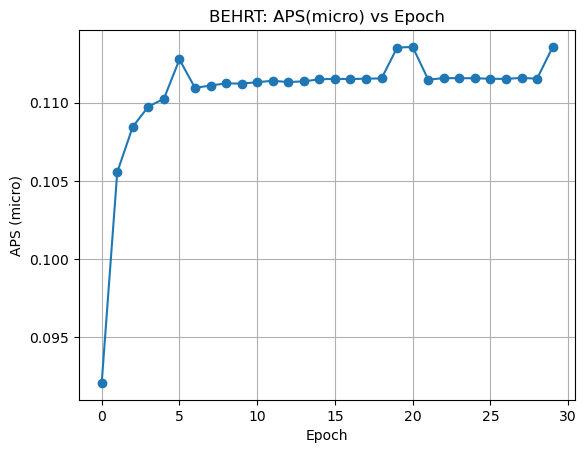

✅ Saved: ../../outputs/ckpts\behrt_aps_vs_epoch.png


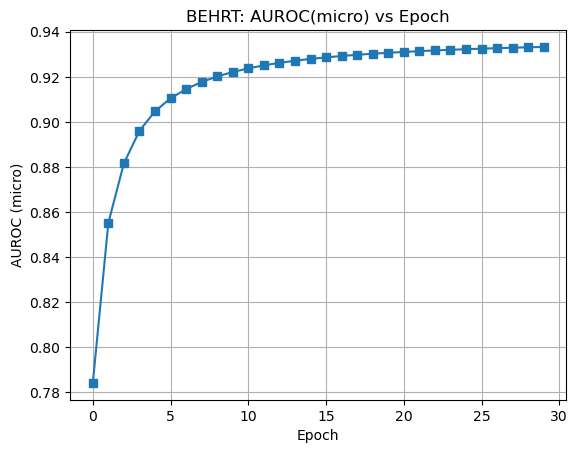

✅ Saved: ../../outputs/ckpts\behrt_auroc_vs_epoch.png


In [41]:
EPOCHS_BEHRT = 30
best_aps = -1.0

aps_list_behrt, auroc_list_behrt, loss_list_behrt = [], [], []
best_ckpt_path = os.path.join(global_params["output_dir"], global_params["best_name"])
print("best_ckpt_path =", best_ckpt_path)

for e in range(EPOCHS_BEHRT):
    tr_loss = train_one_epoch_behrt(behrt_model, trainload, mlb, behrt_optim, device, e, log_every=200)
    aps, auroc, _, _ = eval_behrt(behrt_model, testload, mlb, device)

    loss_list_behrt.append(tr_loss)
    aps_list_behrt.append(aps)
    auroc_list_behrt.append(auroc)

    print(f"==> [BEHRT] epoch {e:02d}: train_loss={tr_loss:.4f} APS={aps:.4f} AUROC={auroc:.4f}")

    if aps > best_aps and global_params.get("save_model", True):
        best_aps = aps
        torch.save(
            (behrt_model.module if hasattr(behrt_model, "module") else behrt_model).state_dict(),
            best_ckpt_path
        )
        print("✅ Saved best ckpt:", best_ckpt_path)

# --- plot APS vs epoch ---
plt.figure()
plt.plot(np.arange(EPOCHS_BEHRT), aps_list_behrt, marker='o')
plt.title("BEHRT: APS(micro) vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("APS (micro)")
plt.grid(True)
aps_png = os.path.join(OUT_DIR, "behrt_aps_vs_epoch.png")
plt.savefig(aps_png, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", aps_png)

# --- plot AUROC vs epoch ---
plt.figure()
plt.plot(np.arange(EPOCHS_BEHRT), auroc_list_behrt, marker='s')
plt.title("BEHRT: AUROC(micro) vs Epoch")
plt.xlabel("Epoch"); plt.ylabel("AUROC (micro)")
plt.grid(True)
auroc_png = os.path.join(OUT_DIR, "behrt_auroc_vs_epoch.png")
plt.savefig(auroc_png, dpi=200, bbox_inches="tight")
plt.show()
print("✅ Saved:", auroc_png)


In [42]:
# load best ckpt and eval no need to retrain
best_ckpt_path = os.path.join(global_params["output_dir"], global_params["best_name"])
state = torch.load(best_ckpt_path, map_location=device)
behrt_model.load_state_dict(state, strict=True)
behrt_model.eval()
print("✅ Loaded best BEHRT ckpt")

aps_behrt, auroc_behrt, y_true_behrt, y_prob_behrt = eval_behrt(behrt_model, testload, mlb, device)
print(f"[BEHRT best] APS={aps_behrt:.4f} AUROC={auroc_behrt:.4f}")


✅ Loaded best BEHRT ckpt


C:\Users\whl19\AppData\Local\Temp\ipykernel_8320\3412743914.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state = torch.load(best_ckpt_path, map_location=device)


[BEHRT best] APS=0.1136 AUROC=0.9310


In [43]:
def build_boc_features(df, token2idx, max_len=None):
    V = len(token2idx)
    X = np.zeros((len(df), V), dtype=np.float32)

    for i, codes in enumerate(df["code"]):
        codes = list(codes)
        if max_len is not None:
            codes = codes[-max_len:]
        for c in codes:
            if c in token2idx:
                X[i, token2idx[c]] = 1.0
    return X

def build_multilabel_targets(df, label_vocab, mlb):
    raw = []
    for labs in df["label"]:
        labs = list(set(list(labs)))
        idxs = [label_vocab.get(x, None) for x in labs]
        idxs = [i for i in idxs if i is not None]
        raw.append(list(set(idxs)))
    return mlb.transform(raw).astype(np.float32)

X_train = build_boc_features(train_df, BertVocab["token2idx"], max_len=global_params["max_len_seq"])
X_test  = build_boc_features(test_df,  BertVocab["token2idx"], max_len=global_params["max_len_seq"])

Y_train = build_multilabel_targets(train_df, Vocab_diag, mlb)
Y_test  = build_multilabel_targets(test_df,  Vocab_diag, mlb)

print("X_train:", X_train.shape, "Y_train:", Y_train.shape)
print("X_test :", X_test.shape,  "Y_test :", Y_test.shape)


X_train: (8784, 4807) Y_train: (8784, 4797)
X_test : (2196, 4807) Y_test : (2196, 4797)


In [44]:
import torch.optim as optim

class TorchLogReg(nn.Module):
    def __init__(self, n_features, n_labels):
        super().__init__()
        self.linear = nn.Linear(n_features, n_labels)
    def forward(self, x):
        return self.linear(x)

X_train_t = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_t  = torch.tensor(X_test,  dtype=torch.float32).to(device)
Y_train_t = torch.tensor(Y_train, dtype=torch.float32).to(device)
Y_test_t  = torch.tensor(Y_test,  dtype=torch.float32).to(device)

n_features = X_train.shape[1]
n_labels   = Y_train.shape[1]

lr_model = TorchLogReg(n_features, n_labels).to(device)
lr_optim = optim.Adam(lr_model.parameters(), lr=1e-3)
criterion = nn.BCEWithLogitsLoss()

EPOCHS_LR = 30
batch_size = 256

for epoch in range(EPOCHS_LR):
    lr_model.train()
    perm = torch.randperm(X_train_t.size(0), device=device)
    total_loss = 0.0

    for i in range(0, X_train_t.size(0), batch_size):
        idx = perm[i:i+batch_size]
        xb = X_train_t[idx]
        yb = Y_train_t[idx]

        lr_optim.zero_grad()
        logits = lr_model(xb)
        loss = criterion(logits, yb)
        loss.backward()
        lr_optim.step()

        total_loss += loss.item() * xb.size(0)

    avg_loss = total_loss / X_train_t.size(0)
    print(f"[Baseline] Epoch {epoch+1}/{EPOCHS_LR} | Loss: {avg_loss:.4f}")

lr_model.eval()
with torch.no_grad():
    probs_lr = torch.sigmoid(lr_model(X_test_t)).cpu().numpy()
y_true_lr = Y_test_t.cpu().numpy()

aps_lr, auroc_lr = micro_metrics(y_true_lr, probs_lr)
print(f"[Baseline LogReg] APS={aps_lr:.4f} AUROC={auroc_lr:.4f}")


[Baseline] Epoch 1/30 | Loss: 0.5937
[Baseline] Epoch 2/30 | Loss: 0.4369
[Baseline] Epoch 3/30 | Loss: 0.3414
[Baseline] Epoch 4/30 | Loss: 0.2801
[Baseline] Epoch 5/30 | Loss: 0.2376
[Baseline] Epoch 6/30 | Loss: 0.2064
[Baseline] Epoch 7/30 | Loss: 0.1825
[Baseline] Epoch 8/30 | Loss: 0.1636
[Baseline] Epoch 9/30 | Loss: 0.1482
[Baseline] Epoch 10/30 | Loss: 0.1354
[Baseline] Epoch 11/30 | Loss: 0.1247
[Baseline] Epoch 12/30 | Loss: 0.1155
[Baseline] Epoch 13/30 | Loss: 0.1076
[Baseline] Epoch 14/30 | Loss: 0.1007
[Baseline] Epoch 15/30 | Loss: 0.0946
[Baseline] Epoch 16/30 | Loss: 0.0892
[Baseline] Epoch 17/30 | Loss: 0.0844
[Baseline] Epoch 18/30 | Loss: 0.0801
[Baseline] Epoch 19/30 | Loss: 0.0761
[Baseline] Epoch 20/30 | Loss: 0.0726
[Baseline] Epoch 21/30 | Loss: 0.0694
[Baseline] Epoch 22/30 | Loss: 0.0664
[Baseline] Epoch 23/30 | Loss: 0.0637
[Baseline] Epoch 24/30 | Loss: 0.0612
[Baseline] Epoch 25/30 | Loss: 0.0589
[Baseline] Epoch 26/30 | Loss: 0.0568
[Baseline] Epoch 27/3

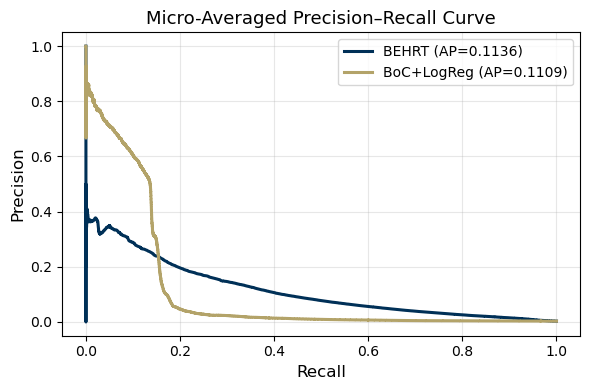

✅ Saved: ../../outputs/ckpts\compare_PR_micro_BEHRT_vs_BoCLogReg.png


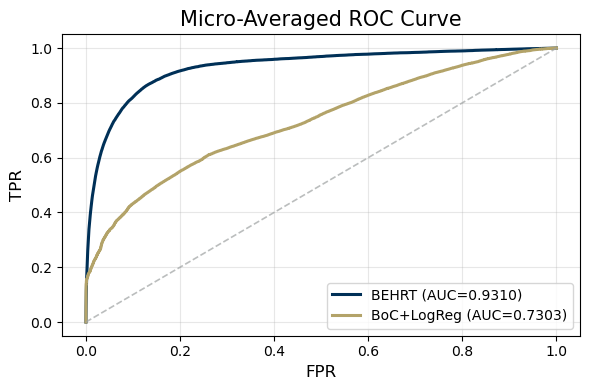

✅ Saved: ../../outputs/ckpts\compare_ROC_micro_BEHRT_vs_BoCLogReg.png


In [ ]:
# micro flatten
y_true_behrt_micro = y_true_behrt.ravel()
y_prob_behrt_micro = y_prob_behrt.ravel()

y_true_lr_micro = y_true_lr.ravel()
probs_lr_micro  = probs_lr.ravel()

# curves
prec_b, rec_b, _ = precision_recall_curve(y_true_behrt_micro, y_prob_behrt_micro)
prec_lr, rec_lr, _ = precision_recall_curve(y_true_lr_micro, probs_lr_micro)

fpr_b, tpr_b, _ = roc_curve(y_true_behrt_micro, y_prob_behrt_micro)
fpr_lr, tpr_lr, _ = roc_curve(y_true_lr_micro, probs_lr_micro)

auc_b  = auc(fpr_b, tpr_b)
auc_lr = auc(fpr_lr, tpr_lr)

# ==========================================================
# COLOR DEFINITIONS (Georgia Tech Color Palette)
GT_BLUE = "#003057"    
GT_GOLD = "#B3A369"    
GREY_LINE = "#9EA2A2"  
# ==========================================================


# ===== PR Curve =====
PR_CMP_PNG = os.path.join(OUT_DIR, "compare_PR_micro_BEHRT_vs_BoCLogReg.png")

plt.figure(figsize=(6,4))
plt.plot(rec_b, prec_b, label=f"BEHRT (AP={aps_behrt:.4f})", color=GT_BLUE, linewidth=2.2)
plt.plot(rec_lr, prec_lr, label=f"BoC+LogReg (AP={aps_lr:.4f})", color=GT_GOLD, linewidth=2.2)

plt.xlabel("Recall", fontsize=12)
plt.ylabel("Precision", fontsize=12)
plt.title("Micro-Averaged Precision–Recall Curve", fontsize=13)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(PR_CMP_PNG, dpi=200)
plt.show()
print("✅ Saved:", PR_CMP_PNG)



# ===== ROC Curve =====
ROC_CMP_PNG = os.path.join(OUT_DIR, "compare_ROC_micro_BEHRT_vs_BoCLogReg.png")

plt.figure(figsize=(6,4))
plt.plot(fpr_b, tpr_b, label=f"BEHRT (AUC={auc_b:.4f})", color=GT_BLUE, linewidth=2.2)
plt.plot(fpr_lr, tpr_lr, label=f"BoC+LogReg (AUC={auc_lr:.4f})", color=GT_GOLD, linewidth=2.2)

# baseline diagonal
plt.plot([0,1], [0,1], linestyle="--", linewidth=1.2, color=GREY_LINE, alpha=0.7)

plt.xlabel("FPR", fontsize=12)
plt.ylabel("TPR", fontsize=12)
plt.title("Micro-Averaged ROC Curve", fontsize=15)
plt.grid(True, alpha=0.3)
plt.legend(fontsize=10)
plt.tight_layout()
plt.savefig(ROC_CMP_PNG, dpi=200)
plt.show()
print("✅ Saved:", ROC_CMP_PNG)


BEHRT  - Micro-AP = 0.1136
BoC+LR - Micro-AP = 0.1109


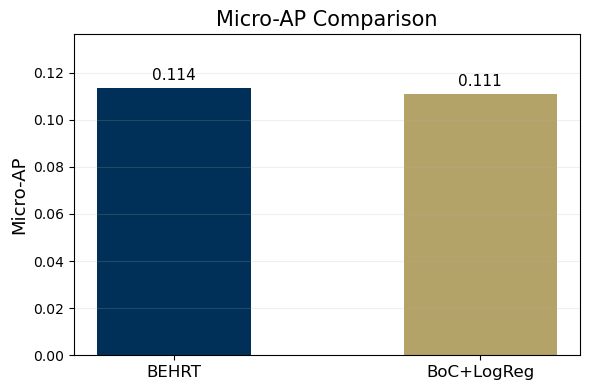

✅ Saved: ../../outputs/ckpts\compare_AP_micro_BEHRT_vs_BoCLogReg.png


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import average_precision_score

# ===== Micro-AP =====
aps_micro_behrt = average_precision_score(
    y_true_behrt.ravel(), 
    y_prob_behrt.ravel()
)
aps_micro_lr = average_precision_score(
    y_true_lr.ravel(), 
    probs_lr.ravel()
)

print(f"BEHRT  - Micro-AP = {aps_micro_behrt:.4f}")
print(f"BoC+LR - Micro-AP = {aps_micro_lr:.4f}")


AP_BAR_PNG = os.path.join(OUT_DIR, "compare_AP_micro_BEHRT_vs_BoCLogReg.png")

models = ["BEHRT", "BoC+LogReg"]
micro_APs = [aps_micro_behrt, aps_micro_lr]

x = np.arange(len(models))

# Georgia Tech official colors
GT_BLUE = "#003057"    
GT_GOLD = "#B3A369"    

plt.figure(figsize=(6,4))

bars = plt.bar(x, micro_APs, color=[GT_BLUE, GT_GOLD], width=0.5)

for i, v in enumerate(micro_APs):
    plt.text(i, v + 0.002, f"{v:.3f}", ha="center", va="bottom", fontsize=11, color="black")

plt.xticks(x, models, fontsize=12)
plt.ylabel("Micro-AP", fontsize=13)
plt.title("Micro-AP Comparison", fontsize=15)

plt.ylim(0, max(micro_APs) * 1.2)
plt.grid(axis="y", alpha=0.2)

plt.tight_layout()
plt.savefig(AP_BAR_PNG, dpi=200)
plt.show()

print("✅ Saved:", AP_BAR_PNG)


Heatmap

In [46]:
# import torch
# device = torch.device("cpu")
# print("Using device:", device)
device = torch.device(global_params['device'])
print("device =", device)


device = cuda:0


In [47]:
token2idx = BertVocab["token2idx"]
idx2token = BertVocab["idx2token"]
PAD_ID = token2idx.get("[PAD]", 0)

def ids_to_tokens(ids_1d, max_len=40):
    ids = ids_1d.detach().cpu().tolist()[:max_len]
    return [idx2token.get(int(i), str(int(i))) for i in ids]


In [ ]:
def pick_one_batch(dataloader):
    return next(iter(dataloader))

def parse_batch(batch):
    seg_ids   = batch[0]   # 0..2
    age_ids   = batch[1]   # 0..4764
    attn_mask = batch[4]   # 0/1 float
    input_ids = batch[5]   # -1..4784
    posi_ids  = batch[7]   # -1..4
    return input_ids, age_ids, seg_ids, posi_ids, attn_mask


In [49]:
def sanitize(input_ids, age_ids, seg_ids, posi_ids):
    input_ids = input_ids.clone()
    posi_ids  = posi_ids.clone()

    input_ids[input_ids < 0] = PAD_ID  # -1 -> [PAD]
    posi_ids[posi_ids < 0] = 0         # -1 -> 0

    return input_ids.long(), age_ids.long(), seg_ids.long(), posi_ids.long()


In [50]:
import math

def _detach_cpu(x): 
    return x.detach().float().cpu()

def register_attention_hooks(model, store):
    handles = []
    layers = model.bert.encoder.layer
    
    for li, layer in enumerate(layers):
        sa = layer.attention.self  # BertSelfAttention

        def make_hook(layer_idx):
            def hook(module, inputs, output):
                hidden_states = inputs[0]
                attention_mask = inputs[1] if len(inputs) > 1 else None

                q = module.transpose_for_scores(module.query(hidden_states))
                k = module.transpose_for_scores(module.key(hidden_states))

                scores = torch.matmul(q, k.transpose(-1, -2)) / math.sqrt(module.attention_head_size)
                if attention_mask is not None:
                    scores = scores + attention_mask

                probs = torch.sigmoid(scores)
                store[layer_idx] = _detach_cpu(probs)
            return hook

        handles.append(sa.register_forward_hook(make_hook(li)))

    return handles

def remove_hooks(handles):
    for h in handles:
        h.remove()


In [ ]:
def sanitize_and_check_all(input_ids, age_ids, seg_ids, posi_ids, attn_mask, model):
    cfg = model.bert.config

    input_ids = input_ids.clone()
    posi_ids  = posi_ids.clone()
    input_ids[input_ids < 0] = PAD_ID
    posi_ids[posi_ids < 0] = 0

    input_ids = input_ids.clamp(0, cfg.vocab_size - 1).long()
    posi_ids  = posi_ids.clamp(0, cfg.max_position_embeddings - 1).long()

    type_hi = getattr(cfg, "type_vocab_size", 2) - 1
    seg_ids = seg_ids.clamp(0, type_hi).long()

    try:
        age_hi = model.bert.embeddings.age_embeddings.num_embeddings - 1
        age_ids = age_ids.clamp(0, age_hi).long()
    except Exception:
        age_ids = age_ids.long()

    def chk(name, x, lo, hi):
        mn, mx = int(x.min().item()), int(x.max().item())
        if mn < lo or mx > hi:
            raise ValueError(f"{name} out of range: min={mn}, max={mx}, expected [{lo},{hi}]")

    chk("input_ids", input_ids, 0, cfg.vocab_size - 1)
    chk("posi_ids",  posi_ids,  0, cfg.max_position_embeddings - 1)
    chk("seg_ids",   seg_ids,   0, type_hi)

    try:
        chk("age_ids", age_ids, 0, age_hi)
    except NameError:
        pass

    return input_ids, age_ids, seg_ids, posi_ids, attn_mask


In [ ]:
def count_nonempty_visits_for_sample(input_ids_row, posi_ids_row, attn_mask_row, pad_id=0):

    L_eff = int(attn_mask_row.sum().item())
    ids = input_ids_row[:L_eff].detach().cpu().numpy().astype(int)
    pos = posi_ids_row[:L_eff].detach().cpu().numpy().astype(int)

    valid_visits = []
    for v in np.unique(pos):
        if v < 0:
            continue
        idx = np.where(pos == v)[0]
        if len(idx) == 0:
            continue
        if np.any(ids[idx] != pad_id):
            valid_visits.append(int(v))
    return len(valid_visits), sorted(valid_visits)

def pick_patient_with_min_nonempty_visits(dataloader, model, min_visits=3, prefer_more=True):
    batch = pick_one_batch(dataloader)
    input_ids, age_ids, seg_ids, posi_ids, attn_mask = parse_batch(batch)

    input_ids, age_ids, seg_ids, posi_ids, attn_mask = sanitize_and_check_all(
        input_ids, age_ids, seg_ids, posi_ids, attn_mask, model
    )

    B = input_ids.size(0)
    best_i = None
    best_cnt = -1
    best_visits = None

    for i in range(B):
        cnt, visits = count_nonempty_visits_for_sample(
            input_ids[i], posi_ids[i], attn_mask[i], pad_id=PAD_ID
        )
        if cnt >= min_visits:
            if not prefer_more:
                return i, cnt, visits
            if cnt > best_cnt:
                best_i, best_cnt, best_visits = i, cnt, visits

    return best_i, best_cnt, best_visits

In [53]:
batch = pick_one_batch(testload)
input_ids, age_ids, seg_ids, posi_ids, attn_mask = parse_batch(batch)

print("Before sanitize:")
print(" input_ids max:", int(input_ids.max()))
print(" age_ids   max:", int(age_ids.max()))
print(" seg_ids   max:", int(seg_ids.max()))
print(" posi_ids  max:", int(posi_ids.max()))

input_ids, age_ids, seg_ids, posi_ids, attn_mask = sanitize_and_check_all(
    input_ids, age_ids, seg_ids, posi_ids, attn_mask, behrt_model
)

print("\nAfter sanitize:")
print(" input_ids max:", int(input_ids.max()))
print(" age_ids   max:", int(age_ids.max()))
print(" seg_ids   max:", int(seg_ids.max()))
print(" posi_ids  max:", int(posi_ids.max()))

print("✅ CPU range check passed (safe to move to GPU)")

Before sanitize:
 input_ids max: 4784
 age_ids   max: 4764
 seg_ids   max: 2
 posi_ids  max: 4

After sanitize:
 input_ids max: 4784
 age_ids   max: 1321
 seg_ids   max: 1
 posi_ids  max: 4
✅ CPU range check passed (safe to move to GPU)


In [54]:
batch = pick_one_batch(testload)
input_ids, age_ids, seg_ids, posi_ids, attn_mask = parse_batch(batch)

print("Before sanitize:")
print(" input_ids max:", int(input_ids.max()))
print(" age_ids   max:", int(age_ids.max()))
print(" seg_ids   max:", int(seg_ids.max()))
print(" posi_ids  max:", int(posi_ids.max()))

input_ids, age_ids, seg_ids, posi_ids, attn_mask = sanitize_and_check_all(
    input_ids, age_ids, seg_ids, posi_ids, attn_mask, behrt_model
)

print("\nAfter sanitize:")
print(" input_ids max:", int(input_ids.max()))
print(" age_ids   max:", int(age_ids.max()))
print(" seg_ids   max:", int(seg_ids.max()))
print(" posi_ids  max:", int(posi_ids.max()))

print("✅ CPU range check passed (safe to move to GPU)")


Before sanitize:
 input_ids max: 4784
 age_ids   max: 4764
 seg_ids   max: 2
 posi_ids  max: 4

After sanitize:
 input_ids max: 4784
 age_ids   max: 1321
 seg_ids   max: 1
 posi_ids  max: 4
✅ CPU range check passed (safe to move to GPU)


In [ ]:
import random
import numpy as np

def list_candidates_in_one_batch(dataloader, model, min_visits=3):
    batch = pick_one_batch(dataloader)
    input_ids, age_ids, seg_ids, posi_ids, attn_mask = parse_batch(batch)

    input_ids, age_ids, seg_ids, posi_ids, attn_mask = sanitize_and_check_all(
        input_ids, age_ids, seg_ids, posi_ids, attn_mask, model
    )

    B = input_ids.size(0)
    cand = []
    for i in range(B):
        cnt, visits = count_nonempty_visits_for_sample(
            input_ids[i], posi_ids[i], attn_mask[i], pad_id=PAD_ID
        )
        if cnt >= min_visits:
            cand.append((i, cnt, visits))
    return cand


In [ ]:
@torch.no_grad()
def collect_attention_once_gpu(model, dataloader, device, sample_idx=0):
    model.eval()

    batch = pick_one_batch(dataloader)
    input_ids, age_ids, seg_ids, posi_ids, attn_mask = parse_batch(batch)

    input_ids, age_ids, seg_ids, posi_ids, attn_mask = sanitize_and_check_all(
        input_ids, age_ids, seg_ids, posi_ids, attn_mask, model
    )

    sl = slice(sample_idx, sample_idx+1)
    input_ids_1 = input_ids[sl].to(device)
    age_ids_1   = age_ids[sl].to(device)
    seg_ids_1   = seg_ids[sl].to(device)
    posi_ids_1  = posi_ids[sl].to(device)
    attn_mask_1 = attn_mask[sl].to(device)

    store = {}
    handles = register_attention_hooks(model, store)

    _ = model(input_ids_1, age_ids_1, seg_ids_1, posi_ids_1, attn_mask_1)

    remove_hooks(handles)
    return input_ids_1, age_ids_1, seg_ids_1, posi_ids_1, attn_mask_1, store
def build_multi_from_one_batch(dataloader, model):
    batch = pick_one_batch(dataloader)
    input_ids, age_ids, seg_ids, posi_ids, attn_mask = parse_batch(batch)

    input_ids, age_ids, seg_ids, posi_ids, attn_mask = sanitize_and_check_all(
        input_ids, age_ids, seg_ids, posi_ids, attn_mask, model
    )

    multi = []
    B = input_ids.size(0)
    for i in range(B):
        L_eff = int(attn_mask[i].sum().item())
        pos_eff = posi_ids[i, :L_eff].detach().cpu().numpy().astype(int)
        uniq_visits = np.unique(pos_eff[pos_eff >= 0]).tolist()
        multi.append((i, uniq_visits))
    return multi

multi = build_multi_from_one_batch(testload, behrt_model)
best_i, best_cnt, best_visits = pick_patient_with_min_nonempty_visits(
    testload, behrt_model, min_visits=3, prefer_more=True
)

if best_i is None:
    print("⚠️ No sample with >=3 non-empty visits found in this batch. Falling back to sample_idx=0")
    best_i = 0
else:
    print(f"✅ Picked sample_idx={best_i} with non-empty visits={best_cnt}, visits={best_visits}")

input_ids_1, age_ids_1, seg_ids_1, posi_ids_1, attn_mask_1, attn_store = collect_attention_once_gpu(
    behrt_model, testload, device, sample_idx=best_i
)

print("layers:", len(attn_store), "| layer0:", attn_store[0].shape)



✅ Picked sample_idx=45 with non-empty visits=3, visits=[0, 1, 2]
layers: 6 | layer0: torch.Size([1, 12, 100, 100])


In [57]:
import numpy as np

def get_last_layer_attn_mean(attn_store):
    last_layer = max(attn_store.keys())
    attn = attn_store[last_layer]      # (1, heads, L, L)
    A = attn[0].mean(dim=0)            # (L, L)
    return last_layer, A

def get_effective_len(attn_mask_1):
    return int(attn_mask_1[0].sum().item())

last_layer, A = get_last_layer_attn_mean(attn_store)
L_eff = get_effective_len(attn_mask_1)

A_eff = A[:L_eff, :L_eff].detach().cpu().numpy()
pos_eff = posi_ids_1[0, :L_eff].detach().cpu().numpy().astype(int)

print("Layer:", last_layer, "| L_eff:", L_eff)
print("pos_eff unique:", np.unique(pos_eff), "| V =", int(pos_eff.max()) + 1)


Layer: 5 | L_eff: 21
pos_eff unique: [0 1 2] | V = 3


In [ ]:
def aggregate_token_attn_to_visit_attn(A_eff, pos_eff):
    V = int(pos_eff.max()) + 1  # assume visits are 0..V-1
    M = np.zeros((V, V), dtype=np.float64)

    idx_by_visit = [np.where(pos_eff == v)[0] for v in range(V)]

    for vq in range(V):
        qi = idx_by_visit[vq]
        if len(qi) == 0:
            continue

        for vk in range(V):
            kj = idx_by_visit[vk]
            if len(kj) == 0:
                continue
            M[vq, vk] = A_eff[np.ix_(qi, kj)].sum()

        # normalize each row by #tokens in query visit
        M[vq, :] /= max(len(qi), 1)

    return M

def row_center(M):
    return M - M.mean(axis=1, keepdims=True)

M = aggregate_token_attn_to_visit_attn(A_eff, pos_eff)
M_centered = row_center(M)

print("M shape:", M.shape)
print("row sums (raw M):", M.sum(axis=1))


M shape: (3, 3)
row sums (raw M): [10.16072559 10.07570863 10.12425014]


✅ Saved: figures/behrt/visit_attn_layer5.png


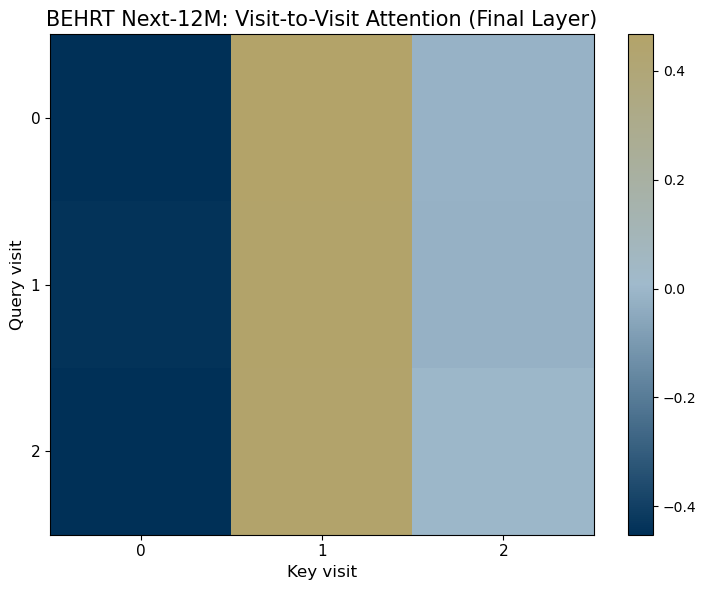

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import numpy as np
import os

GT_COLORS = ["#003057", "#A0BACC", "#B3A369"]
custom_cmap = mcolors.LinearSegmentedColormap.from_list("gt_cmap", GT_COLORS)

PR_CMP_PNG = "figures/behrt/visit_attn_layer5.png"

def plot_visit_to_visit_heatmap(M_centered, title):
    V = M_centered.shape[0]
    plt.figure(figsize=(7.5, 6))

    im = plt.imshow(M_centered, aspect="auto", cmap=custom_cmap)

    plt.title(title, fontsize=15)
    plt.xlabel("Key visit", fontsize=12)
    plt.ylabel("Query visit", fontsize=12)

    plt.xticks(range(V), fontsize=11)
    plt.yticks(range(V), fontsize=11)

    cbar = plt.colorbar(im)
    cbar.ax.tick_params(labelsize=10)

    plt.tight_layout()

    os.makedirs(os.path.dirname(PR_CMP_PNG), exist_ok=True)
    plt.savefig(PR_CMP_PNG, dpi=200, bbox_inches="tight")
    print("✅ Saved:", PR_CMP_PNG)

    plt.show()
    plt.close()

plot_visit_to_visit_heatmap(
    M_centered,
    title="BEHRT Next-12M: Visit-to-Visit Attention (Final Layer)"
)

In [ ]:
import torch
import numpy as np

PAD_ID = token2idx.get("[PAD]", 0)

def decode_token(i: int):
    return idx2token.get(int(i), str(int(i)))

def summarize_patient_visit_level(
    input_ids_1, age_ids_1, seg_ids_1, posi_ids_1, attn_mask_1,
    max_visits=None,
    show_age=True,
    hide_special=True,
):

    L_eff = int(attn_mask_1[0].sum().item())
    ids = input_ids_1[0, :L_eff].detach().cpu().tolist()
    pos = posi_ids_1[0, :L_eff].detach().cpu().tolist()
    age = age_ids_1[0, :L_eff].detach().cpu().tolist()

    # ---- visits ----
    visits = sorted(set(int(v) for v in pos))
    if max_visits is not None:
        visits = visits[:max_visits]

    lines = []
    lines.append("🧾 Patient — Input (Visit History, visit-level):")

    for v in visits:
        idxs = [i for i, pv in enumerate(pos) if int(pv) == int(v)]

        toks = []
        ages = []
        for i in idxs:
            tid = int(ids[i])
            if tid == PAD_ID:
                continue
            tok = decode_token(tid)

            if hide_special and tok.startswith("[") and tok.endswith("]"):
                continue

            toks.append(tok)
            ages.append(int(age[i]))

        visit_age = None
        if show_age and len(ages) > 0:
            vals, cnts = np.unique(np.array(ages), return_counts=True)
            visit_age = int(vals[np.argmax(cnts)])

        if show_age:
            lines.append(f"  Visit {v} (age {visit_age if visit_age is not None else 'NA'}): {toks}")
        else:
            lines.append(f"  Visit {v}: {toks}")

    print("\n".join(lines))
    return lines


summarize_patient_visit_level(
    input_ids_1, age_ids_1, seg_ids_1, posi_ids_1, attn_mask_1,
    show_age=True
)


🧾 Patient — Input (Visit History, visit-level):
  Visit 0 (age 1321): ['30751', '96972', '9992', '4489', 'E8789', '5970']
  Visit 1 (age 1321): ['29530', '68110', 'E9689', '78079', 'E8791', 'E8490', '3099', '9726']
  Visit 2 (age 1321): ['78461', '78051', '04111', '30390', '30491', '99657', '5303']


['🧾 Patient — Input (Visit History, visit-level):',
 "  Visit 0 (age 1321): ['30751', '96972', '9992', '4489', 'E8789', '5970']",
 "  Visit 1 (age 1321): ['29530', '68110', 'E9689', '78079', 'E8791', 'E8490', '3099', '9726']",
 "  Visit 2 (age 1321): ['78461', '78051', '04111', '30390', '30491', '99657', '5303']"]

In [ ]:
@torch.no_grad()
def predict_next_visit_probs_from_logits(
    model, input_ids, age_ids, seg_ids, posi_ids, attn_mask
):
    model.eval()

    out = model(input_ids, age_ids, seg_ids, posi_ids, attn_mask)

    logits = out[0] if isinstance(out, (tuple, list)) else out

    if logits.dim() == 3:
        L_eff = int(attn_mask[0].sum().item())
        logits = logits[:, L_eff - 1, :]   # (1, vocab)

    probs = torch.sigmoid(logits)   
    return probs[0]                 

In [62]:
probs = predict_next_visit_probs_from_logits(
    behrt_model,
    input_ids_1,
    age_ids_1,
    seg_ids_1,
    posi_ids_1,
    attn_mask_1
)

topk = 10
vals, idxs = torch.topk(probs, k=topk)

print("\n🎯 Output (Top-k predicted codes):")
for rank, (p, i) in enumerate(zip(vals.tolist(), idxs.tolist()), 1):
    print(f"  {rank:>2}. {decode_token(i):<10}  {p*100:5.1f}%")



🎯 Output (Top-k predicted codes):
   1. 3970         35.5%
   2. 42761        34.9%
   3. 42682        28.2%
   4. 58389        22.8%
   5. 24901        19.2%
   6. 41189        18.4%
   7. 2713         18.0%
   8. 51851        16.6%
   9. 5970         15.8%
  10. 5303         14.0%


In [ ]:
topk = 5
vals, idxs = torch.topk(probs, k=topk)

top_probs = vals.tolist()
top_codes = [decode_token(i) for i in idxs.tolist()]

print("\n🎯 Output (Top-k predicted codes):")
for rank, (code, p) in enumerate(zip(top_codes, top_probs), 1):
    print(f"  {rank:>2}. {code:<10}  {p*100:5.1f}%")

code2desc = {
    "42761": "Supraventricular tachycardia (SVT)",
    "3970":  "Rheumatic mitral valve disease",
    "42682": "Left bundle branch block (LBBB)",
    "58389": "Nephropathy / nephritis",
    "24901": "Diabetes with ketoacidosis",
    "2713":  "Alkalosis",
    "41189": "Other acute ischemic heart disease",
    "51851": "Acute respiratory failure (post-op / trauma)",
    "5970":  "Urethritis",
    "5303":  "Esophageal stenosis"
}



🎯 Output (Top-k predicted codes):
   1. 3970         35.5%
   2. 42761        34.9%
   3. 42682        28.2%
   4. 58389        22.8%
   5. 24901        19.2%


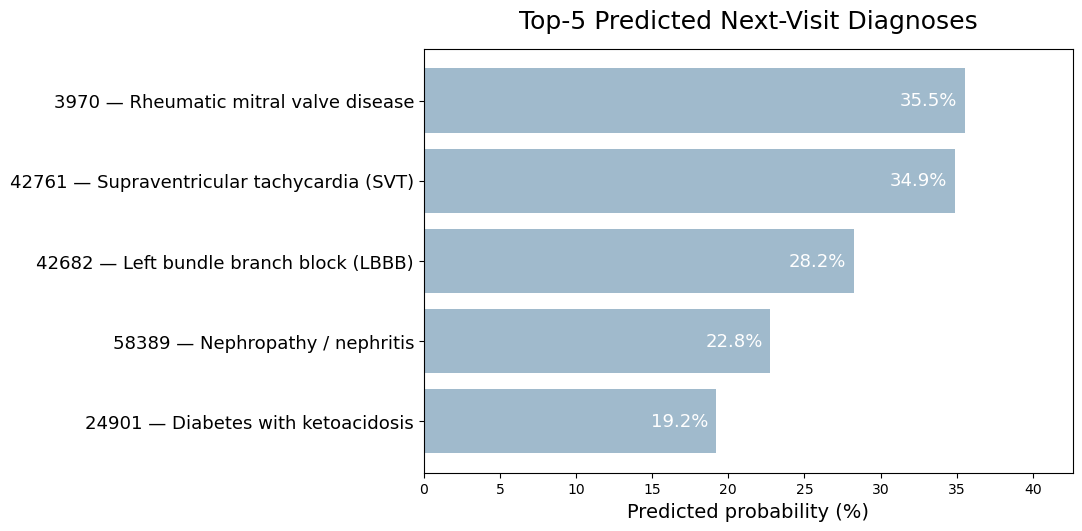

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

probs_percent = [p * 100 for p in top_probs]

labels = [f"{code} — {code2desc.get(code, '')}" for code in top_codes]
y_pos = np.arange(len(labels))

fig, ax = plt.subplots(figsize=(11, 5.5))

bars = ax.barh(y_pos, probs_percent, color="#A0BACC")
# customize y-axis labels
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=13, linespacing=1.15)

# bigger title & axis labels
ax.set_xlabel("Predicted probability (%)", fontsize=14)
ax.set_title("Top-5 Predicted Next-Visit Diagnoses", fontsize=18, pad=15)

# invert so highest is on top
ax.invert_yaxis()

# give a bit of space to the right
ax.set_xlim(0, max(probs_percent) * 1.20)

# Write white percentage text inside bars
for bar, v in zip(bars, probs_percent):
    ax.text(
        bar.get_width() - 0.5,
        bar.get_y() + bar.get_height()/2,
        f"{v:.1f}%",
        ha="right",
        va="center",
        color="white",
        fontsize=13
    )

# more space on the left for labels
plt.subplots_adjust(left=0.38, right=0.97, top=0.92, bottom=0.15)

plt.show()


In [ ]:
behrt_model.bert.config.num_hidden_layers # Transformer layers: 6

6

Top Indications

In [ ]:
import numpy as np
from collections import defaultdict

L_eff = int(attn_mask_1[0].sum().item())

ids_eff = input_ids_1[0, :L_eff].detach().cpu().numpy().astype(int)

codes_eff = [idx2token.get(int(i), str(int(i))) for i in ids_eff]

print("L_eff:", L_eff)
print("First 20 codes:", codes_eff[:20])


L_eff: 45
First 20 codes: ['5967', '78933', '7991', '4843', '2848', '1962', '3970', '1980', '78461', '4928', '1963', '1971', '1987', '42682', 'V1204', '1973', '5110', 'V652', '4230', '[PAD]']


In [ ]:
layer = 5  
A = attn_store[layer][0].mean(dim=0)             # (L, L)
A_eff = A[:L_eff, :L_eff].detach().cpu().numpy() # (L_eff, L_eff)
print("A_eff shape:", A_eff.shape)


A_eff shape: (45, 45)


In [ ]:
def top_codes_by_attention_received(codes_eff, A_eff, k=10, exclude_tokens={"[PAD]"}):
    """
    codes_eff: length L list of code strings
    A_eff: (L, L) attention probs
    return: list of (code, score)
    """
    token_received = A_eff.sum(axis=0)  # how much each token is attended to (from all queries)
    code_score = defaultdict(float)

    for code, s in zip(codes_eff, token_received):
        if code in exclude_tokens:
            continue
        code_score[code] += float(s)

    top = sorted(code_score.items(), key=lambda x: x[1], reverse=True)[:k]
    return top

top10 = top_codes_by_attention_received(codes_eff, A_eff, k=10)
print("Top Codes by Attention (Top-10):")
for code, score in top10:
    print(f"  • {code:>8s}  {score:.4f}")


Top Codes by Attention (Top-10):
  •     1971  1.0218
  •    78933  1.0089
  •     3970  1.0089
  •     4843  1.0076
  •     7991  1.0057
  •     1980  1.0012
  •     1973  1.0009
  •     5967  1.0001
  •    78461  0.9981
  •     4230  0.9976


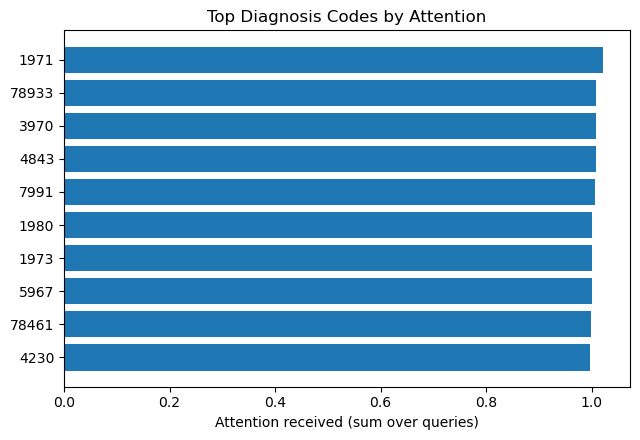

In [ ]:
import matplotlib.pyplot as plt

def plot_top_codes_bar(top_items, title="Top Codes by Attention"):
    codes = [c for c, _ in top_items][::-1]
    scores = [s for _, s in top_items][::-1]

    plt.figure(figsize=(6.5, 4.5))
    plt.barh(range(len(codes)), scores)
    plt.yticks(range(len(codes)), codes)
    plt.xlabel("Attention received (sum over queries)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_top_codes_bar(top10, title=f"Top Diagnosis Codes by Attention")


In [ ]:
pos_eff = posi_ids_1[0, :L_eff].detach().cpu().numpy().astype(int)

def top_codes_by_attention_per_visit(codes_eff, pos_eff, A_eff, k=5):
    token_received = A_eff.sum(axis=0)  # (L,)
    V = int(pos_eff.max()) + 1
    out = {}

    for v in range(V):
        idx = np.where(pos_eff == v)[0]
        code_score = defaultdict(float)
        for i in idx:
            code_score[codes_eff[i]] += float(token_received[i])
        top = sorted(code_score.items(), key=lambda x: x[1], reverse=True)[:k]
        out[v] = top
    return out

top_by_visit = top_codes_by_attention_per_visit(
    codes_eff,
    pos_eff,
    A_eff,
    k=5
)

for v, items in top_by_visit.items():
    items = [(c, s) for c, s in items if c != "[PAD]"]
    if len(items) == 0:
        print(f"\nVisit {v}: no non-PAD codes (padding-dominated)")
    else:
        print(f"\nVisit {v} Top codes:")
        for c, s in items:
            print(f"  • {c:>8s}  {s:.4f}")




Visit 0 Top codes:
  •    78933  1.0089
  •     3970  1.0089
  •     4843  1.0076
  •     7991  1.0057
  •     1980  1.0012

Visit 1 Top codes:
  •     1971  1.0218
  •     1973  1.0009
  •    78461  0.9981
  •     4230  0.9976
  •    42682  0.9927

Visit 2: no non-PAD codes (padding-dominated)

Visit 3: no non-PAD codes (padding-dominated)

Visit 4: no non-PAD codes (padding-dominated)


Top Predictions

In [ ]:
import torch

behrt_model.eval()

with torch.no_grad():
    logits = behrt_model(
        input_ids_1,
        age_ids_1,
        seg_ids_1,
        posi_ids_1,
        attn_mask_1
    )
    # logits shape: (1, num_codes)

probs = torch.sigmoid(logits)[0]  # (num_codes,)
print("num prediction codes:", probs.shape[0])


num prediction codes: 4797


In [ ]:
def get_top_prediction_codes(probs, idx2token, k=5):
    """
    probs: Tensor (num_codes,)
    return: list of (code_str, probability)
    """
    topk = torch.topk(probs, k)
    out = []
    for idx, score in zip(topk.indices, topk.values):
        code = idx2token.get(int(idx), str(int(idx)))
        out.append((code, float(score)))
    return out

top_preds = get_top_prediction_codes(probs, idx2token, k=5)

print("Top Predicted Diagnosis Codes:")
for code, p in top_preds:
    print(f"  • {code:>8s}  ({p:.4f})")


Top Predicted Diagnosis Codes:
  •     3970  (0.3537)
  •    42761  (0.3523)
  •    42682  (0.2797)
  •    58389  (0.2273)
  •    24901  (0.1916)


In [ ]:
EXCLUDE = {"[PAD]", "[CLS]", "[SEP]"}

def get_top_prediction_codes_filtered(probs, idx2token, k=5, exclude=EXCLUDE):
    items = []
    for i, p in enumerate(probs):
        code = idx2token.get(int(i), str(int(i)))
        if code in exclude:
            continue
        items.append((code, float(p)))

    items = sorted(items, key=lambda x: x[1], reverse=True)[:k]
    return items

top_preds = get_top_prediction_codes_filtered(probs, idx2token, k=5)

print("Top Predicted Diagnosis Codes (filtered):")
for code, p in top_preds:
    print(f"  • {code:>8s}  ({p:.4f})")


Top Predicted Diagnosis Codes (filtered):
  •     3970  (0.3537)
  •    42761  (0.3523)
  •    42682  (0.2797)
  •    58389  (0.2273)
  •    24901  (0.1916)
